In [2]:
import datatable as dt
#import nltk
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

d:\venv_python\text_mining\lib\site-packages\datatable\__init__.py:155: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  init_styles()
d:\venv_python\text_mining\lib\site-packages\datatable\__init__.py:155: DeprecationWarning: Importing update_display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  init_styles()


d:\venv_python\text_mining\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
d:\venv_python\text_mining\lib\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
d:\venv_python\text_mining\lib\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
d:\venv_python\text_mining\lib\site-packages\keras\utils\image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
d:\venv_python\text_mining\lib\site-package

In [3]:
import nltk
# nltk.download('stopwords')

### Stop Words

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english') #spanish
stop_words.extend(['\n', 'nan'])
stop_words.extend(['stay', 'stayed', 'service', 'got', 'room', 'night', 'food', 'did', 'rooms', 
'day', 'resort', 'hotel', 'beach', 'staff', 'great', 'good', 'nice'])

### Dataset

In [5]:
df = pd.read_csv('../Datasets/tripadvisor_hotel_reviews.csv', decimal = '.', sep = ',')

conditions = [df.Rating.isin([1,2]), df.Rating.isin([3]), df.Rating.isin([4,5])]
values = [0,0,1]

df['Cluster'] =np.select(conditions, values)

df

,Review,Rating,Cluster
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,1
20487,great location price view hotel great quick pl...,4,1
20488,"ok just looks nice modern outside, desk staff ...",2,0
20489,hotel theft ruined vacation hotel opened sept ...,1,0


### Tokenize words and Clean-up text

In [6]:
data = df[df['Cluster'] == 1 ]

In [7]:
%%time
# Convert to list
data = data.Review.astype('str') # DESCRIPCION OBSERVACIONES
data = data.values.tolist()


tokens = [t.lower() for t in data if t.lower() not in stop_words]
tokens = [re.sub('\s+', ' ', sent) for sent in tokens]
tokens = [re.sub('\d', ' ', sent) for sent in tokens] #Removes numbers
tokens = [re.sub(' +', ' ', sent) for sent in tokens] #Removes multiple whitespaces
tokens = [str(sent).strip() for sent in tokens] #Removes whitespace before and after the token
tokens = [re.sub('[^A-Za-z0-9]+', ' ', sent) for sent in tokens] #Removes special characters


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(tokens))

data_words[:10]

CPU times: total: 5.67 s
Wall time: 5.74 s


[['nice',
  'hotel',
  'expensive',
  'parking',
  'got',
  'good',
  'deal',
  'stay',
  'hotel',
  'anniversary',
  'arrived',
  'late',
  'evening',
  'took',
  'advice',
  'previous',
  'reviews',
  'did',
  'valet',
  'parking',
  'check',
  'quick',
  'easy',
  'little',
  'disappointed',
  'non',
  'existent',
  'view',
  'room',
  'room',
  'clean',
  'nice',
  'size',
  'bed',
  'comfortable',
  'woke',
  'stiff',
  'neck',
  'high',
  'pillows',
  'not',
  'soundproof',
  'like',
  'heard',
  'music',
  'room',
  'night',
  'morning',
  'loud',
  'bangs',
  'doors',
  'opening',
  'closing',
  'hear',
  'people',
  'talking',
  'hallway',
  'maybe',
  'just',
  'noisy',
  'neighbors',
  'aveda',
  'bath',
  'products',
  'nice',
  'did',
  'not',
  'goldfish',
  'stay',
  'nice',
  'touch',
  'taken',
  'advantage',
  'staying',
  'longer',
  'location',
  'great',
  'walking',
  'distance',
  'shopping',
  'overall',
  'nice',
  'experience',
  'having',
  'pay',
  'parking'

### Creating Bigram and Trigram Models

In [8]:
%%time
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=20, threshold=0.2) # higher threshold fewer phrases. valores entre 0 y uno
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: total: 11 s
Wall time: 11.1 s


In [9]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[1452]]])

['outstanding', 'price_location', 'awesome', 'arrived', 'no', 'day', 'holiday', 'greeted', 'warm_welcome', 'chateau', 'lemoyne', 'desk', 'upgraded_suite', 'booked', 'free', 'cocktail', 'reception', 'lounge', 'room_beautiful', 'clean', 'balcony', 'courtyard', 'netya', 'desk', 'soooo', 'sweet', 'stay', 'everytime', 'visit', 'location_best']


### Remove Stopwords, Make Bigrams and Lemmatize

In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# !spacy download es_core_news_md

In [12]:
# !spacy download en_core_web_sm


In [13]:
%%time
#Let’s call the functions in order.
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'es' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) #es_core_news_md

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['expensive', 'parking', 'deal', 'anniversary', 'arrived_late', 'evening', 'previous_review', 'valet_parke', 'easy', 'little_disappointed', 'non_existent', 'view', 'clean', 'size_be', 'comfortable', 'wake', 'stiff', 'neck', 'high', 'pillow', 'soundproof', 'hear', 'music', 'morning', 'loud', 'bang', 'door', 'open', 'close', 'hear_people', 'talk', 'hallway', 'maybe', 'noisy', 'neighbor', 'aveda', 'bath_product', 'goldfish', 'touch', 'take', 'advantage', 'stay', 'long', 'location_walking', 'distance', 'shopping', 'overall_experience', 'pay', 'parking']]
CPU times: total: 2min 3s
Wall time: 2min 6s


### Create the Dictionary and Corpus needed for Topic Modeling

In [14]:
%%time
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


CPU times: total: 1.98 s
Wall time: 1.95 s


In [15]:
id2word[2]

'arrived_late'

In [16]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[('advantage', 1),
  ('anniversary', 1),
  ('arrived_late', 1),
  ('aveda', 1),
  ('bang', 1),
  ('bath_product', 1),
  ('clean', 1),
  ('close', 1),
  ('comfortable', 1),
  ('deal', 1),
  ('distance', 1),
  ('door', 1),
  ('easy', 1),
  ('evening', 1),
  ('expensive', 1),
  ('goldfish', 1),
  ('hallway', 1),
  ('hear', 1),
  ('hear_people', 1),
  ('high', 1),
  ('little_disappointed', 1),
  ('location_walking', 1),
  ('long', 1),
  ('loud', 1),
  ('maybe', 1),
  ('morning', 1),
  ('music', 1),
  ('neck', 1),
  ('neighbor', 1),
  ('noisy', 1),
  ('non_existent', 1),
  ('open', 1),
  ('overall_experience', 1),
  ('parking', 2),
  ('pay', 1),
  ('pillow', 1),
  ('previous_review', 1),
  ('shopping', 1),
  ('size_be', 1),
  ('soundproof', 1),
  ('stay', 1),
  ('stiff', 1),
  ('take', 1),
  ('talk', 1),
  ('touch', 1),
  ('valet_parke', 1),
  ('view', 1),
  ('wake', 1)],
 [('goldfish', 1),
  ('touch', 1),
  ('animal', 2),
  ('area', 1),
  ('bathrobe', 1),
  ('big', 1),
  ('brandi', 1),
  

### Building the Topic Model

* chunksize: is the number of documents to be used in each training chunk. 
* update_every: determines how often the model parameters should be updated and 
* passes: is the total number of training passes.

In [17]:
%%time
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20,
                                           alpha='auto',
                                           #per_word_topics=True
                                             )

CPU times: total: 1min 41s
Wall time: 1min 42s


In [18]:
# Print the Keyword in the 3 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.007*"breakfast" + 0.006*"location" + 0.006*"excellent" + 0.005*"place" + '
  '0.005*"small" + 0.005*"area" + 0.005*"bathroom" + 0.005*"view" + '
  '0.005*"bed" + 0.004*"walk"'),
 (1,
  '0.010*"time" + 0.010*"go" + 0.009*"pool" + 0.007*"people" + 0.007*"drink" + '
  '0.006*"want" + 0.006*"restaurant" + 0.005*"say" + 0.005*"water" + '
  '0.005*"leave"')]


### Compute Model Perplexity and Coherence Score

In [19]:
# Compute Perplexity
# print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.33546986637612936


### Visualize the topics-keywords

In [20]:
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
# feed the LDA model into the pyLDAvis instance
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

d:\venv_python\text_mining\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=             x    y  topics  cluster       Freq
topic                                          
0      0.12743  0.0       1        1  56.757402
1     -0.12743  0.0       2        1  43.242598, topic_info=         Term         Freq        Total Category  logprob  loglift
654      pool  3462.000000  3462.000000  Default  30.0000  30.0000
398    people  2931.000000  2931.000000  Default  29.0000  29.0000
222     drink  2768.000000  2768.000000  Default  28.0000  28.0000
135        go  4653.000000  4653.000000  Default  27.0000  27.0000
292  location  3262.000000  3262.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
197      well  1556.690322  3106.999424   Topic2  -5.5529   0.1472
91      think  1481.630932  2681.670791   Topic2  -5.6023   0.2450
160     place  1677.995156  4445.956888   Topic2  -5.4778  -0.1361
382      love  1464.859550  3010.922791   Topic2  -5.6137   0.1179
153      make  1336.213572  2392.145247   Topic2  -5.7056   0.2560

[171 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
201       1  0.992706    access
201       2  0.007666    access
95        1  0.001189  activity
95        2  0.999729  activity
778       1  0.253125   amazing
...     ...       ...       ...
269       1  0.999102   weekend
269       2  0.001042   weekend
197       1  0.498874      well
197       2  0.501127      well
615       1  0.999023    window

[263 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

### Finding the optimal number of topics for LDA

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state = 100, update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [22]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=10, step=1)

CPU times: total: 9min 23s
Wall time: 10min 53s


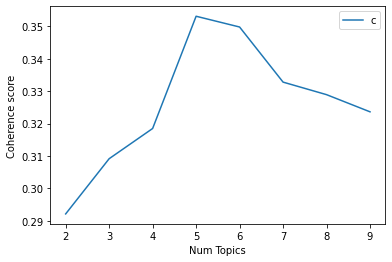

In [23]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [24]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2921
Num Topics = 3  has Coherence Value of 0.3092
Num Topics = 4  has Coherence Value of 0.3185
Num Topics = 5  has Coherence Value of 0.3531
Num Topics = 6  has Coherence Value of 0.3498
Num Topics = 7  has Coherence Value of 0.3328
Num Topics = 8  has Coherence Value of 0.3289
Num Topics = 9  has Coherence Value of 0.3236


Se escogió 2 Clusters porque a partir de 3 empieza a haber solapamiento y algunos clusters quedan vacios o con pocos registros

### Functions to sort the data

In [21]:
###############Finding the dominant topic in each sentence
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

##################Find the most representative document for each topic
def most_representative_records(df_topic_sents_keywords):
    # Group top 5 sentences under each topic
    sent_topics_sorteddf = pd.DataFrame()

    sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

    for i, grp in sent_topics_outdf_grpd:
        sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

    # Reset Index    
    sent_topics_sorteddf.reset_index(drop=True, inplace=True)

    # Format
    sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
    
    return sent_topics_sorteddf

################Topic distribution across documents
def topic_distribution(df_topic_sents_keywords):
    # Number of Documents for Each Topic
    topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

    # Percentage of Documents for Each Topic
    topic_contribution = round(topic_counts/topic_counts.sum(), 4)

    # Topic Number and Keywords
    topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].value_counts()
    topic_num_keywords = pd.DataFrame(topic_num_keywords)
    topic_num_keywords = topic_num_keywords.reset_index().drop(0, axis=1)

    # Concatenate Column wise
    df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)
    df_dominant_topics = df_dominant_topics.reset_index()
    df_dominant_topics = pd.concat([topic_num_keywords, df_dominant_topics], axis=1)
    # Change Column names
    df_dominant_topics.columns = ['Dominant_topic', 'Topic_Keywords', 'to_delete', 'Num_Documents', 'Perc_Documents']
    del  df_dominant_topics['to_delete']

    # Show
    return df_dominant_topics

### Finding the dominant topic in each sentence

In [22]:
optimal_model = lda_model 

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

C:\Users\John\AppData\Local\Temp\ipykernel_2100\4071306711.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\John\AppData\Local\Temp\ipykernel_2100\4071306711.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.8891,"breakfast, location, excellent, place, small, ...",nice hotel expensive parking got good deal sta...
1,1,0,0.7285,"breakfast, location, excellent, place, small, ...","unique, great stay, wonderful time hotel monac..."
2,2,0,0.5099,"breakfast, location, excellent, place, small, ...","great stay great stay, went seahawk game aweso..."
3,3,0,0.5857,"breakfast, location, excellent, place, small, ...",love monaco staff husband stayed hotel crazy w...
4,4,0,0.9115,"breakfast, location, excellent, place, small, ...","cozy stay rainy city, husband spent 7 nights m..."
5,5,0,0.7494,"breakfast, location, excellent, place, small, ...","excellent staff, housekeeping quality hotel ch..."
6,6,0,0.9030,"breakfast, location, excellent, place, small, ...","hotel stayed hotel monaco cruise, rooms genero..."
7,7,0,0.9111,"breakfast, location, excellent, place, small, ...",excellent stayed hotel monaco past w/e delight...
8,8,0,0.7476,"breakfast, location, excellent, place, small, ...",nice value seattle stayed 4 nights late 2007. ...
9,9,0,0.9188,"breakfast, location, excellent, place, small, ...",nice hotel good location hotel kimpton design ...


### Find the most representative document for each topic

In [23]:
pd.set_option('display.max_colwidth', None)
sent_topics_sorteddf = most_representative_records(df_topic_sents_keywords)
sent_topics_sorteddf

Topic_Num  Topic_Perc_Contrib  \
0          0              0.9930   
1          1              0.9955   

                                                                        Keywords  \
0  breakfast, location, excellent, place, small, area, bathroom, view, bed, walk   
1             time, go, pool, people, drink, want, restaurant, say, water, leave   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

### Topic distribution across documents

In [24]:
df_dominant_topics = topic_distribution(df_topic_sents_keywords)
df_dominant_topics

,Dominant_topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0,"breakfast, location, excellent, place, small, area, bathroom, view, bed, walk",11831,0.7839
1,1,"time, go, pool, people, drink, want, restaurant, say, water, leave",3262,0.2161


# WordCloud

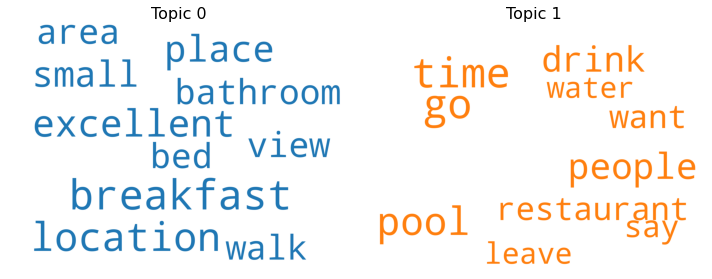

In [25]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()